In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects

import matplotlib.pyplot as plt
import cv2
import os
import csv
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
## Load RetinaNet model
model = keras.models.load_model('/path_to_the_model/model_val_loss.h5', custom_objects=custom_objects)

/home/huangbo/.local/lib/python3.5/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_1" during training.
  sample_weight_mode=sample_weight_mode)


In [5]:
## load the image list from csv file
csv_data_file = '/csv/validation.csv'
test_img_list = []

with open(csv_data_file, 'r') as f_in:
    csvreader = csv.reader(f_in, delimiter=',')
    for row in csvreader:
        img_filepath, x1, y1, x2, y2, classname = row
        test_img_list.append(img_filepath)

In [12]:
## load class mapping
csv_class_file = '/csv/class_mapping.csv'
classes = {}
with open(csv_class_file, 'r') as f_class_in:
    csvreader = csv.reader(f_class_in, delimiter=',')
    for classname, class_id in csvreader:
        classes[classname] = int(class_id)
        
inv_map = {v: k for k, v in classes.items()}

In [7]:
## pick a image
img_index = 0
img_path = test_img_list[img_index]

processing time:  0.24218463897705078


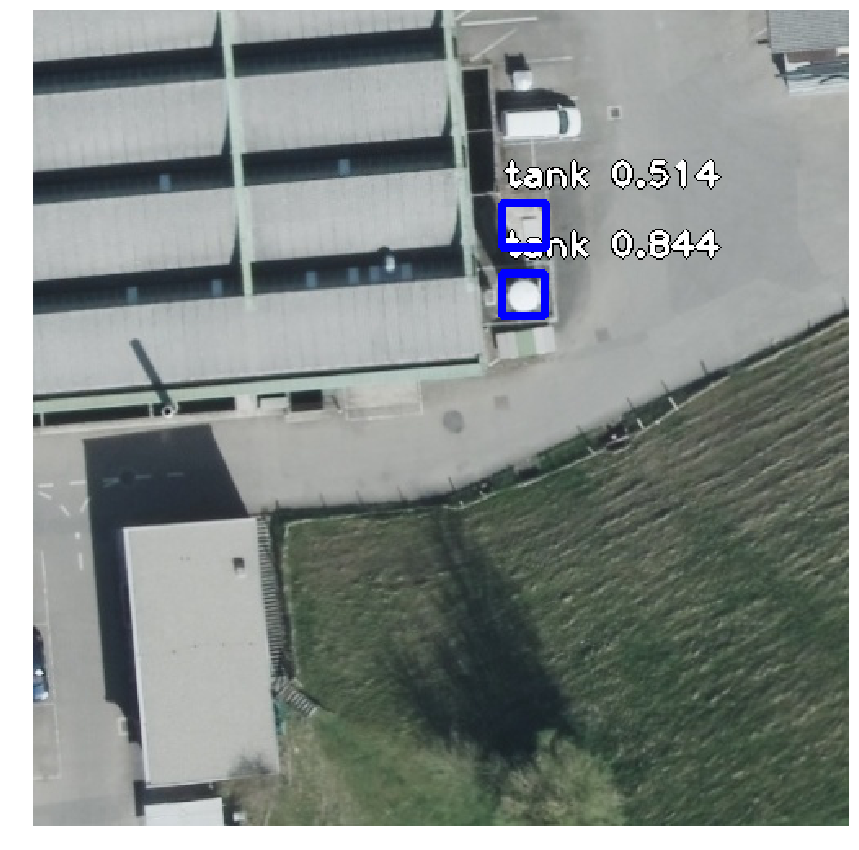

In [21]:
## read image
image = cv2.imread(img_path)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    
# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(inv_map[label], score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()